In [2]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import folium

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# IMPORTING THE TAXI DATASETS

taxi_parser = lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

## Use this link to get taxi_data: 
## https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
jan_taxi_training = pd.read_csv('raw_data/green_tripdata_2014-01.csv', 
                                index_col = False, parse_dates =
                                ['lpep_pickup_datetime', 'Lpep_dropoff_datetime'], 
                                date_parser = taxi_parser)
feb_taxi_training = pd.read_csv('raw_data/green_tripdata_2014-02.csv', 
                                index_col = False, parse_dates =
                                ['lpep_pickup_datetime', 'Lpep_dropoff_datetime'], 
                                date_parser = taxi_parser)
taxi_training = pd.concat([jan_taxi_training, feb_taxi_training])

jan_taxi_testing = pd.read_csv('raw_data/green_tripdata_2015-01.csv', 
                               index_col = False, parse_dates =
                                ['lpep_pickup_datetime', 'Lpep_dropoff_datetime'], 
                               date_parser = taxi_parser)
feb_taxi_testing = pd.read_csv('raw_data/green_tripdata_2015-02.csv', 
                               index_col = False, parse_dates =
                                ['lpep_pickup_datetime', 'Lpep_dropoff_datetime'], 
                               date_parser = taxi_parser)
taxi_testing = pd.concat([jan_taxi_testing, feb_taxi_testing])

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/green_tripdata_2014-01.csv'

(1809054, 20)
Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'Total_amount',
       'Payment_type', 'Trip_type '],
      dtype='object')
VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
Lpep_dropoff_datetime    datetime64[ns]
Store_and_fwd_flag               object
RateCodeID                        int64
Pickup_longitude                float64
Pickup_latitude                 float64
Dropoff_longitude               float64
Dropoff_latitude                float64
Passenger_count                   int64
Trip_distance                   float64
Fare_amount                     float64
Extra                           float64
MTA_tax                         float64
Tip_amount              

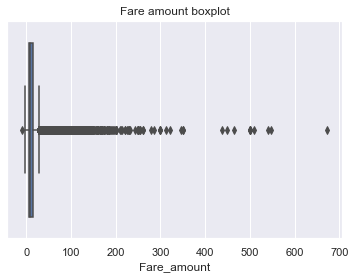

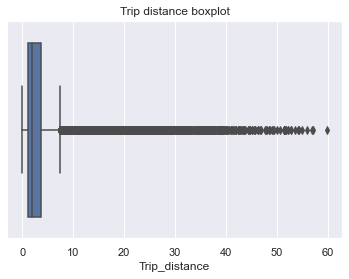

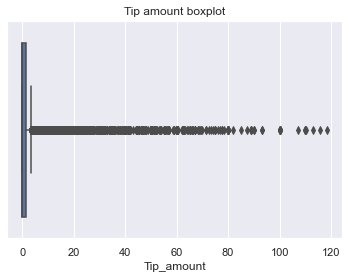

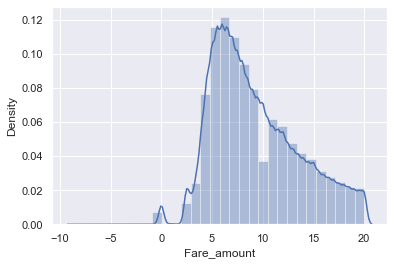

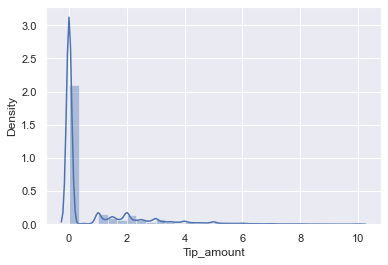

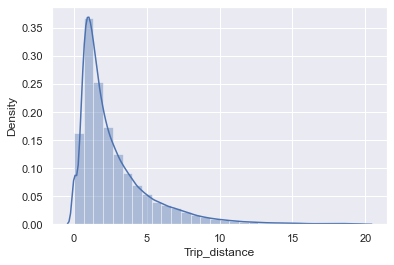

In [17]:
# TAXI DATA DESCRIPTIVE STATISTICS
print(taxi_training.shape)
print(taxi_training.columns)
print(taxi_training.dtypes)
print(taxi_training.isnull().sum())
print(taxi_training.nunique())
print(taxi_training.describe())
print(taxi_training.head())

print(taxi_testing.isnull().sum())

# TAXI OUTLIER DETECTION
fig, ax = plt.subplots()
sns.boxplot(taxi_training['Fare_amount'], ax = ax)
ax.set_title('Fare amount boxplot')
plt.savefig('plots/Fare_amount_boxplot.png')

fig, ax = plt.subplots()
sns.boxplot(taxi_training['Trip_distance'], ax = ax)
ax.set_title('Trip distance boxplot')
plt.savefig('plots/Trip_distance_boxplot.png')

fig, ax = plt.subplots()
sns.boxplot(taxi_training['Tip_amount'], ax = ax)
ax.set_title('Tip amount boxplot')
plt.savefig('plots/Tip_amount_boxplot.png')

# REMOVING OUTLIERS FROM THE TAXI DATASET
taxi_training = taxi_training.loc[taxi_training['Fare_amount'] < 700]
taxi_testing = taxi_testing.loc[taxi_testing['Fare_amount'] < 700]

taxi_training = taxi_training.loc[taxi_training['Tip_amount'] < 125]
taxi_testing = taxi_testing.loc[taxi_testing['Tip_amount'] < 125]

taxi_training = taxi_training.loc[taxi_training['Trip_distance'] < 60]
taxi_testing = taxi_testing.loc[taxi_testing['Trip_distance'] < 60]

## PRELIMINARY ATTRIBUTE ANALYSIS
fare_data = taxi_training.loc[taxi_training['Fare_amount'] <= 20, 'Fare_amount']
fig, ax = plt.subplots()
sns.distplot(fare_data, bins = 30)
plt.savefig('plots/Fare_distribution.png')

tip_data = taxi_training.loc[taxi_training['Tip_amount'] <= 10, 'Tip_amount']
fig, ax = plt.subplots()
sns.distplot(tip_data, bins = 30)
plt.savefig('plots/Tip_distribution.png')

trip_data = taxi_training.loc[taxi_training['Trip_distance'] <= 20, 'Trip_distance']
fig, ax = plt.subplots()
sns.distplot(trip_data, bins = 30)
plt.savefig('plots/Trip_distribution.png')

In [3]:
# IMPORTING EXTERNAL DATASETS
income_data = pd.read_csv('raw_data/Median Incomes.csv', 
                        skiprows = 4)
rent_data = pd.read_csv('raw_data/Median Monthly Rent.csv', 
                        skiprows = 4)

In [4]:
# DESCRIPTIVE STATISTICS OF EXTERNAL DATASETS
print(income_data.shape)
print(income_data.columns)
print(income_data.dtypes)
print(income_data.isnull().sum())
print(income_data.nunique())
print(income_data.head())

print(rent_data.shape)
print(rent_data.columns)
print(rent_data.dtypes)
print(rent_data.isnull().sum())
print(rent_data.nunique())
print(rent_data.head())

(6068, 6)
Index(['Location', 'Household Type', 'TimeFrame', 'DataFormat', 'Data',
       'Fips'],
      dtype='object')
Location          object
Household Type    object
TimeFrame          int64
DataFormat        object
Data              object
Fips               int64
dtype: object
Location          0
Household Type    0
TimeFrame         0
DataFormat        0
Data              0
Fips              0
dtype: int64
Location           246
Household Type       4
TimeFrame           15
DataFormat           1
Data              5740
Fips               246
dtype: int64
  Location             Household Type  TimeFrame DataFormat         Data  Fips
0  Astoria  Families without Children       2019    Dollars        92755   401
1  Astoria     Families with Children       2019    Dollars        75972   401
2  Astoria                   Families       2019    Dollars        88662   401
3  Astoria             All Households       2019    Dollars        79180   401
4  Astoria  Families without Children

In [5]:
# CLEANING EXTERNAL DATASETS
income_data = income_data.rename(columns = {'Data': 'Income'})
rent_data = rent_data.rename(columns = {'Data': 'Rent'})

income_data = income_data.loc[income_data["Household Type"] == 'All Households']

gentrification_data = pd.merge(income_data, rent_data, on = ['Fips', 'TimeFrame'])

gentrification_data = gentrification_data.loc[gentrification_data['Fips'] < 1000]

gentrification_data['Income'] = gentrification_data.Income.astype(float)

# Now ensure that all instances in Manhattan (below W 110St/E 96th St) are deleted
manhattan_fips = [101, 102, 103, 104, 105, 106, 107, 108, 164]
gentrification_data = gentrification_data[~gentrification_data.Fips.isin(manhattan_fips)]

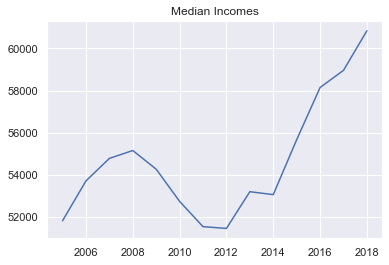

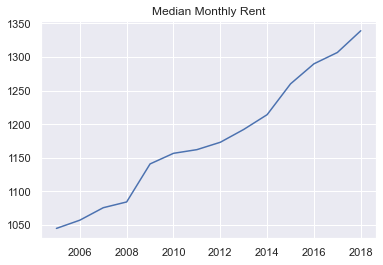

In [6]:
# VISUALISATION of income and rent in NYC boroughs over years
x_data = range(gentrification_data.TimeFrame.min(), gentrification_data.TimeFrame.max())
income_means = []
rent_means = []
for year in range(gentrification_data.TimeFrame.min(), gentrification_data.TimeFrame.max()):
    temp_income = gentrification_data.loc[gentrification_data['TimeFrame'] == year]
    income_means.append(temp_income['Income'].mean())
    temp_rent = gentrification_data.loc[gentrification_data['TimeFrame'] == year]
    rent_means.append(temp_income['Rent'].mean())

fig, ax = plt.subplots()
ax.plot(x_data, income_means)
ax.set_title('Median Incomes')
plt.savefig('plots/MedianIncomes.png')

fig, ax = plt.subplots()
ax.plot(x_data, rent_means)
ax.set_title('Median Monthly Rent')
plt.savefig('plots/MedianRent.png')

In [22]:
# SPLITTING EXTERNAL DATA INTO TRAINING AND TESTING
gentrification_training = gentrification_data.loc[gentrification_data['TimeFrame'] == 2014, 
                                                  ['Income', 'Rent', 'Fips']]
gentrification_testing = gentrification_data.loc[gentrification_data['TimeFrame'] == 2015, 
                                                 ['Income', 'Rent', 'Fips']]

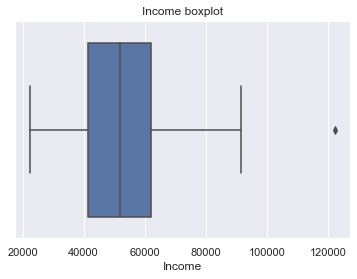

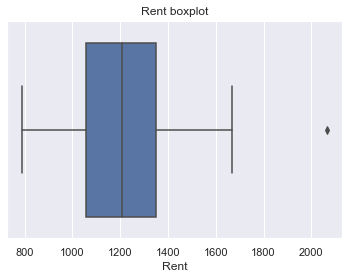

In [24]:
# OUTLIER HANDLING FOR EXTERNAL DATA
fig, ax = plt.subplots()
sns.boxplot(gentrification_training['Income'], ax = ax)
ax.set_title('Income boxplot')
plt.savefig('plots/Income_boxplot.png')

fig, ax = plt.subplots()
sns.boxplot(gentrification_training['Rent'], ax = ax)
ax.set_title('Rent boxplot')
plt.savefig('plots/Rent_boxplot.png')

gentrification_training = gentrification_training.loc[gentrification_training['Income'] < 100000]
gentrification_testing = gentrification_testing.loc[gentrification_testing['Income'] < 100000]

gentrification_training = gentrification_training.loc[gentrification_training['Rent'] < 1800]
gentrification_testing = gentrification_testing.loc[gentrification_testing['Rent'] < 1800]

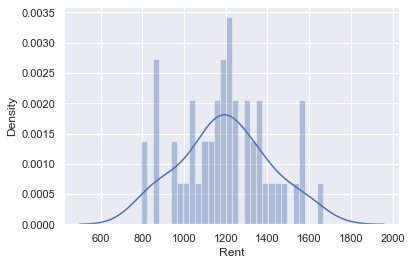

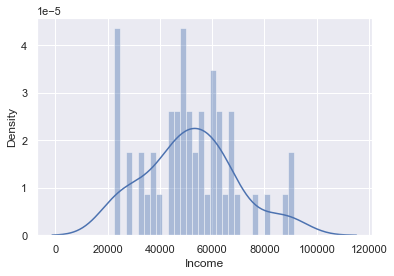

In [25]:
# VISUALISATIONS of the distribution of median income and median rent
rent_data = gentrification_training.loc[gentrification_training['Rent'] <= 15000, 'Rent']
fig, ax = plt.subplots()
sns.distplot(rent_data, bins = 30)
plt.savefig('plots/Rent_distribution.png')

income_data = gentrification_training.loc[gentrification_training['Income'] <= 100000, 'Income']
fig, ax = plt.subplots()
sns.distplot(income_data, bins = 30)
plt.savefig('plots/Income_distribution.png')

In [26]:
# MERGING THE DATASETS
gdf_training = gpd.GeoDataFrame(taxi_training, 
                                geometry = gpd.points_from_xy(taxi_training.Pickup_longitude, 
                                                              taxi_training.Pickup_latitude))
gdf_testing = gpd.GeoDataFrame(taxi_testing, 
                               geometry = gpd.points_from_xy(taxi_testing.Pickup_longitude, 
                                                             taxi_testing.Pickup_latitude))
geojson_file = 'raw_data/Community Districts.geojson'
census_districts = gpd.read_file(geojson_file)

districts_taxi_train = gpd.sjoin(gdf_training, census_districts, op = 'within')
districts_taxi_train = districts_taxi_train.rename(columns = {'boro_cd': 'Fips'})

districts_taxi_test = gpd.sjoin(gdf_testing, census_districts, op = 'within')
districts_taxi_test = districts_taxi_test.rename(columns = {'boro_cd': 'Fips'})

districts_taxi_train['Fips'] = districts_taxi_train['Fips'].astype(int)
districts_taxi_test['Fips'] = districts_taxi_test['Fips'].astype(int)

training_data = districts_taxi_train.merge(gentrification_training, how = 'inner', on = 'Fips')
testing_data = districts_taxi_test.merge(gentrification_testing, how = 'inner', on = 'Fips')

training_data = pd.DataFrame(training_data)
testing_data = pd.DataFrame(testing_data)

In [27]:
# CLEANING AND PROCESSING THE MERGED DATASETS
training_data = training_data[training_data.VendorID.isin([1, 2])]
training_data = training_data[training_data.Payment_type.isin([1, 2])]
training_data['VendorID'] = training_data['VendorID'].astype(bool)
training_data['Payment_type'] = training_data['Payment_type'].astype(bool)
training_data['Trip_type '] = training_data['Trip_type '].astype(bool)
encoder = pd.get_dummies(training_data.RateCodeID)
training_data = pd.concat([training_data, encoder], axis = 1)
training_data = training_data.rename(columns = {1: 'RateCodeID_1', 2: 'RateCodeID_2', 
                                                3: 'RateCodeID_3', 4: 'RateCodeID_4',
                                                5: 'RateCodeID_5', 6: 'RateCodeID_6'})
training_data = training_data.drop(['RateCodeID'], axis = 1)
training_data = training_data.replace(to_replace = '#VALUE!', value=np.nan)
training_data = training_data.loc[training_data['Fare_amount'] >= 0.0]
training_data = training_data.loc[training_data['Trip_distance'] >= 0.0]
training_data = training_data.loc[training_data['Tip_amount'] >= 0.0]
training_data['Trip_distance'] = training_data['Trip_distance'].replace(to_replace = 0.00000, 
                                                                        value = 0.00001)
training_data['Tip_amount'] = training_data['Tip_amount'].replace(to_replace = 0.00000, 
                                                                  value = 0.00001)
training_data['Tip_amount'] = np.log(training_data['Tip_amount'])
training_data['Trip_distance'] = np.log(training_data['Trip_distance'])
training_data['Fare_sum'] = training_data.groupby('Fips')['Fare_amount'].transform('sum')

testing_data = testing_data[testing_data.VendorID.isin([1, 2])]
testing_data = testing_data[testing_data.Payment_type.isin([1, 2])]
testing_data['VendorID'] = testing_data['VendorID'].astype(bool)
testing_data['Payment_type'] = testing_data['Payment_type'].astype(bool)
testing_data['Trip_type '] = testing_data['Trip_type '].astype(bool)
encoder = pd.get_dummies(testing_data.RateCodeID)
testing_data = pd.concat([testing_data, encoder], axis = 1)
testing_data = testing_data.rename(columns = {1: 'RateCodeID_1', 2: 'RateCodeID_2', 
                                              3: 'RateCodeID_3', 4: 'RateCodeID_4',
                                              5: 'RateCodeID_5', 6: 'RateCodeID_6'})
testing_data = testing_data.drop(['RateCodeID'], axis = 1)
testing_data = testing_data.replace(to_replace = '#VALUE!', value=np.nan)
testing_data = testing_data.loc[testing_data['Fare_amount'] >= 0.0]
testing_data = testing_data.loc[testing_data['Trip_distance'] >= 0.0]
testing_data = testing_data.loc[testing_data['Tip_amount'] >= 0.0]
testing_data['Trip_distance'] = testing_data['Trip_distance'].replace(to_replace = 0.00000, 
                                                                      value = 0.00001)
testing_data['Tip_amount'] = testing_data['Tip_amount'].replace(to_replace = 0.00000, 
                                                                value = 0.00001)
testing_data['Tip_amount'] = np.log(testing_data['Tip_amount'])
testing_data['Trip_distance'] = np.log(testing_data['Trip_distance'])

training_data = training_data.drop(['Store_and_fwd_flag', 'Pickup_longitude', 'Pickup_latitude', 
                                    'Dropoff_longitude', 'Dropoff_latitude', 'Pickup_longitude', 
                                    'Pickup_latitude', 'geometry', 'index_right', 'shape_area', 
                                    'shape_leng'], axis = 1)
testing_data = testing_data.drop(['Store_and_fwd_flag', 'Pickup_longitude', 'Pickup_latitude', 
                                  'Dropoff_longitude', 'Dropoff_latitude', 'improvement_surcharge', 
                                  'geometry', 'index_right', 'shape_area', 'shape_leng'], axis = 1)

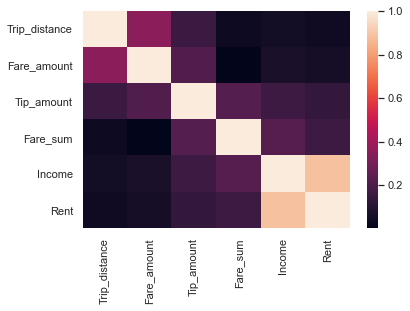

In [28]:
# INTERACTION VISUALISATIONS
sns.heatmap(training_data[['Trip_distance', 'Fare_amount', 'Tip_amount', 'Fare_sum', 'Income', 
                           'Rent']].corr())
plt.savefig('plots/correlation_heatmap.png')

In [29]:
# GEOSPATIAL VISUALISATIONS
training_data['Fips'] = training_data['Fips'].astype(str)
testing_data['Fips'] = testing_data['Fips'].astype(str)

nyc_map1 = folium.Map(location = [40.693943, -73.985880], default_zoom_start = 20)
nyc_map1.add_child(folium.Choropleth(geo_data = 'Community Districts.geojson', name = 'choropleth', 
                                     data = training_data, 
                                     columns = ['Fips', 'Fare_sum'], 
                                     key_on = 'feature.properties.boro_cd', fill_color = 'OrRd', 
                                     nan_fill_color = None, fill_opacity = 0.6, line_opacity = 1, 
                                     legend_name = 'Sum of all Fares'))
nyc_map1.save('FareSumTrainingChoroplethMap.html')

nyc_map1 = folium.Map(location = [40.693943, -73.985880], default_zoom_start = 20)
nyc_map1.add_child(folium.Choropleth(geo_data = 'Community Districts.geojson', name = 'choropleth', 
                                     data = training_data, 
                                     columns = ['Fips', 'Income'], 
                                     key_on = 'feature.properties.boro_cd', fill_color = 'OrRd', 
                                     nan_fill_color = None, fill_opacity = 0.6, line_opacity = 1, 
                                     legend_name = 'Income'))
nyc_map1.save('TrainingIncomeChorplethMap.html')

nyc_map1 = folium.Map(location = [40.693943, -73.985880], default_zoom_start = 20)
nyc_map1.add_child(folium.Choropleth(geo_data = 'Community Districts.geojson', name = 'choropleth', 
                                     data = training_data, 
                                     columns = ['Fips', 'Rent'], 
                                     key_on = 'feature.properties.boro_cd', fill_color = 'OrRd', 
                                     nan_fill_color = None, fill_opacity = 0.6, line_opacity = 1, 
                                     legend_name = 'Rent'))
nyc_map1.save('TrainingRentChorplethMap.html')

training_data['Fips'] = training_data['Fips'].astype(int)
testing_data['Fips'] = testing_data['Fips'].astype(int)

In [30]:
# FEATURE ENGINEERING
X_datasets = [training_data, testing_data]

for dataset in X_datasets:
    dataset['pickup_month'] = dataset['lpep_pickup_datetime'].dt.month
    dataset['pickup_day'] = dataset['lpep_pickup_datetime'].dt.day
    dataset['pickup_day_of_week'] = dataset['lpep_pickup_datetime'].dt.dayofweek
    dataset['pickup_hour'] = dataset['lpep_pickup_datetime'].dt.hour

    dataset['dropoff_month'] = dataset['Lpep_dropoff_datetime'].dt.month
    dataset['dropoff_day'] = dataset['Lpep_dropoff_datetime'].dt.day
    dataset['dropoff_day_of_week'] = dataset['Lpep_dropoff_datetime'].dt.dayofweek
    dataset['dropoff_hour'] = dataset['Lpep_dropoff_datetime'].dt.hour

    dataset.drop(['lpep_pickup_datetime', 'Lpep_dropoff_datetime'], axis = 1, inplace = True)

In [42]:
# Subsampling the data for modelling
training_data = training_data.loc[np.random.choice(training_data.index, 10000, replace = False)]
testing_data = testing_data.loc[np.random.choice(testing_data.index, 10000, replace = False)]

test_fips = testing_data['Fips']
print(test_fips)

X_train = training_data.loc[:, training_data.columns != 'Fare_amount']
X_test = testing_data.loc[:, testing_data.columns != 'Fare_amount']
y_train = training_data.loc[:, training_data.columns == 'Fare_amount']
y_test = testing_data.loc[:, testing_data.columns == 'Fare_amount']

# IMPUTATION
categorical_train = X_train[['VendorID', 'Payment_type', 'Trip_type ', 'RateCodeID_1', 
                             'RateCodeID_2', 'RateCodeID_3', 'RateCodeID_4', 'RateCodeID_5', 
                             'RateCodeID_6', 'pickup_month', 'pickup_day', 'pickup_day_of_week', 
                             'pickup_hour', 'dropoff_month', 'dropoff_day', 'dropoff_day_of_week', 
                             'dropoff_hour']]
categorical_test = X_test[['VendorID', 'Payment_type', 'Trip_type ', 'RateCodeID_1', 
                             'RateCodeID_2', 'RateCodeID_3', 'RateCodeID_4', 'RateCodeID_5', 
                             'RateCodeID_6', 'pickup_month', 'pickup_day', 'pickup_day_of_week', 
                             'pickup_hour', 'dropoff_month', 'dropoff_day', 'dropoff_day_of_week', 
                             'dropoff_hour']]

categorical_imputer = SimpleImputer(strategy = 'most_frequent')
categorical_imputer = categorical_imputer.fit(categorical_train)
categorical_train = categorical_imputer.transform(categorical_train)
categorical_test = categorical_imputer.transform(categorical_test)

num_train = X_train[['Passenger_count', 'Trip_distance', 'Extra', 'MTA_tax', 'Tip_amount', 
                     'Tolls_amount', 'Ehail_fee', 'Total_amount']]
num_test = X_test[['Passenger_count', 'Trip_distance', 'Extra', 'MTA_tax', 'Tip_amount', 
                     'Tolls_amount', 'Ehail_fee', 'Total_amount']]

num_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
num_imputer = num_imputer.fit(num_train)
num_train = num_imputer.transform(num_train)
num_test = num_imputer.transform(num_test)

X_train = np.concatenate((categorical_train, num_train), axis = 1)
X_test = np.concatenate((categorical_test, num_test), axis = 1)

1240972    302
725281     301
496685     403
579425     301
2230930    303
          ... 
2303648    303
2800409    309
84853      401
948994     112
1571420    111
Name: Fips, Length: 10000, dtype: int64


In [32]:
# MODELLING
random_forest = RandomForestRegressor(n_estimators = 1000, random_state = 42)
random_forest = random_forest.fit(X_train, y_train.values.ravel())
accuracy = random_forest.score(X_test, y_test)
print('Accuracy: ', acc)
predictions = random_forest.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))

Accuracy:  0.9640016429748951
Mean Squared Error: 1.3694771683870994
Root Mean Squared Error: 1.1702466271633085
Mean Absolute Error: 0.369061512


In [60]:
# FINAL VISUALISATIONS
data = {"Predictions": predictions, "Fips": test_fips}
predictions_together = pd.DataFrame(data)
predictions_together['Fare_sum'] = predictions_together.groupby('Fips')['Predictions'].transform('sum')
predictions_together['Fips'] = predictions_together['Fips'].astype(str)

nyc_map1 = folium.Map(location = [40.693943, -73.985880], default_zoom_start = 20)
nyc_map1.add_child(folium.Choropleth(geo_data = 'Community Districts.geojson', name = 'choropleth', 
                                     data = predictions_together, 
                                     columns = ['Fips', 'Fare_sum'], 
                                     key_on = 'feature.properties.boro_cd', fill_color = 'OrRd', 
                                     nan_fill_color = None, fill_opacity = 0.6, line_opacity = 1, 
                                     legend_name = 'Sum of all Fares'))
nyc_map1.save('FareSumPredictionChoroplethMap.html')